In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# LOADING THE NECESSARY LIBRARIES

In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import nltk
from sklearn.preprocessing import LabelBinarizer
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from wordcloud import WordCloud,STOPWORDS
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize,sent_tokenize
from bs4 import BeautifulSoup
import re,string,unicodedata
from keras.preprocessing import text, sequence
from sklearn.metrics import classification_report,confusion_matrix,accuracy_score
from sklearn.model_selection import train_test_split
from string import punctuation
from nltk import pos_tag
from nltk.corpus import wordnet
import keras
from keras.models import Sequential
from keras.layers import Dense,Embedding,LSTM,Dropout
from keras.callbacks import ReduceLROnPlateau
import tensorflow as tf

# IMPORTING THE DATASET

In [3]:
true = pd.read_csv("/content/drive/MyDrive/Fake-news/True.csv")
false = pd.read_csv("/content/drive/MyDrive/Fake-news/Fake.csv")

# DATA VISUALIZATION AND PREPROCESSING

In [4]:
true.head()

title  \
0  As U.S. budget fight looms, Republicans flip t...   
1  U.S. military to accept transgender recruits o...   
2  Senior U.S. Republican senator: 'Let Mr. Muell...   
3  FBI Russia probe helped by Australian diplomat...   
4  Trump wants Postal Service to charge 'much mor...   

                                                text       subject  \
0  WASHINGTON (Reuters) - The head of a conservat...  politicsNews   
1  WASHINGTON (Reuters) - Transgender people will...  politicsNews   
2  WASHINGTON (Reuters) - The special counsel inv...  politicsNews   
3  WASHINGTON (Reuters) - Trump campaign adviser ...  politicsNews   
4  SEATTLE/WASHINGTON (Reuters) - President Donal...  politicsNews   

                 date  
0  December 31, 2017   
1  December 29, 2017   
2  December 31, 2017   
3  December 30, 2017   
4  December 29, 2017

In [5]:
false.head()

title  \
0   Donald Trump Sends Out Embarrassing New Year’...   
1   Drunk Bragging Trump Staffer Started Russian ...   
2   Sheriff David Clarke Becomes An Internet Joke...   
3   Trump Is So Obsessed He Even Has Obama’s Name...   
4   Pope Francis Just Called Out Donald Trump Dur...   

                                                text subject  \
0  Donald Trump just couldn t wish all Americans ...    News   
1  House Intelligence Committee Chairman Devin Nu...    News   
2  On Friday, it was revealed that former Milwauk...    News   
3  On Christmas day, Donald Trump announced that ...    News   
4  Pope Francis used his annual Christmas Day mes...    News   

                date  
0  December 31, 2017  
1  December 31, 2017  
2  December 30, 2017  
3  December 29, 2017  
4  December 25, 2017

In [6]:
true['category'] = 1
false['category'] = 0

In [7]:
df = pd.concat([true,false]) #Merging the 2 datasets

**SO, WE CAN SEE THAT THE DATASET IS BALANCED**

In [8]:
df.head()

title  \
0  As U.S. budget fight looms, Republicans flip t...   
1  U.S. military to accept transgender recruits o...   
2  Senior U.S. Republican senator: 'Let Mr. Muell...   
3  FBI Russia probe helped by Australian diplomat...   
4  Trump wants Postal Service to charge 'much mor...   

                                                text       subject  \
0  WASHINGTON (Reuters) - The head of a conservat...  politicsNews   
1  WASHINGTON (Reuters) - Transgender people will...  politicsNews   
2  WASHINGTON (Reuters) - The special counsel inv...  politicsNews   
3  WASHINGTON (Reuters) - Trump campaign adviser ...  politicsNews   
4  SEATTLE/WASHINGTON (Reuters) - President Donal...  politicsNews   

                 date  category  
0  December 31, 2017          1  
1  December 29, 2017          1  
2  December 31, 2017          1  
3  December 30, 2017          1  
4  December 29, 2017          1

In [9]:
df.isna().sum() # Checking for nan Values

title       0
text        0
subject     0
date        0
category    0
dtype: int64

In [10]:
df.title.count()

44898

In [11]:
df.subject.value_counts()

subject
politicsNews       11272
worldnews          10145
News                9050
politics            6841
left-news           4459
Government News     1570
US_News              783
Middle-east          778
Name: count, dtype: int64

<ipython-input-12-8a7d6c397771>:4: UserWarning: FixedFormatter should only be used together with FixedLocator
  chart.set_xticklabels(chart.get_xticklabels(),rotation=90)


[Text(0, 0, 'politicsNews'),
 Text(1, 0, 'worldnews'),
 Text(2, 0, 'News'),
 Text(3, 0, 'politics'),
 Text(4, 0, 'Government News'),
 Text(5, 0, 'left-news'),
 Text(6, 0, 'US_News'),
 Text(7, 0, 'Middle-east')]

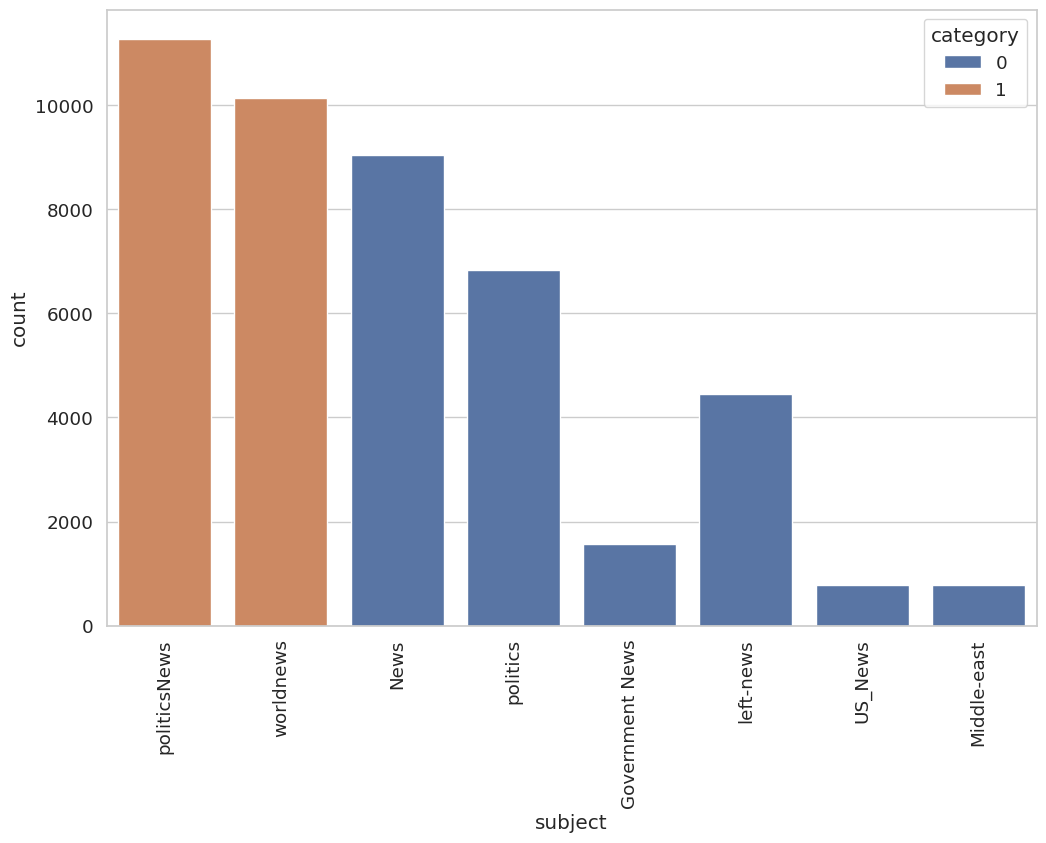

In [12]:
plt.figure(figsize = (12,8))
sns.set(style = "whitegrid",font_scale = 1.2)
chart = sns.countplot(x = "subject", hue = "category" , data = df)
chart.set_xticklabels(chart.get_xticklabels(),rotation=90)

**SINCE THE TOPICS IN SUBJECT COLUMN ARE DIFFERENT FOR BOTH CATEGORIES, HENCE WE HAVE TO EXCLUDE IT FROM FINAL TEXT COLUMN**

In [13]:
df['text'] = df['text'] + " " + df['title']
del df['title']
del df['subject']
del df['date']

**WHAT ARE STOPWORDS?**

**Stopwords are the English words which does not add much meaning to a sentence. They can safely be ignored without sacrificing the meaning of the sentence. For example, the words like the, he, have etc. Such words are already captured this in corpus named corpus. We first download it to our python environment.**

In [15]:
import nltk
nltk.download('stopwords')
stop = set(stopwords.words('english'))
punctuation = list(string.punctuation)
stop.update(punctuation)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


**DATA CLEANING**

In [16]:
def strip_html(text):
    soup = BeautifulSoup(text, "html.parser")
    return soup.get_text()

#Removing the square brackets
def remove_between_square_brackets(text):
    return re.sub('\[[^]]*\]', '', text)
# Removing URL's
def remove_between_square_brackets(text):
    return re.sub(r'http\S+', '', text)
#Removing the stopwords from text
def remove_stopwords(text):
    final_text = []
    for i in text.split():
        if i.strip().lower() not in stop:
            final_text.append(i.strip())
    return " ".join(final_text)
#Removing the noisy text
def denoise_text(text):
    text = strip_html(text)
    text = remove_between_square_brackets(text)
    text = remove_stopwords(text)
    return text
#Apply function on review column
df['text']=df['text'].apply(denoise_text)

<ipython-input-16-4f1d5a4b9299>:2: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  soup = BeautifulSoup(text, "html.parser")


**WORDCLOUD FOR REAL TEXT (LABEL - 1)**

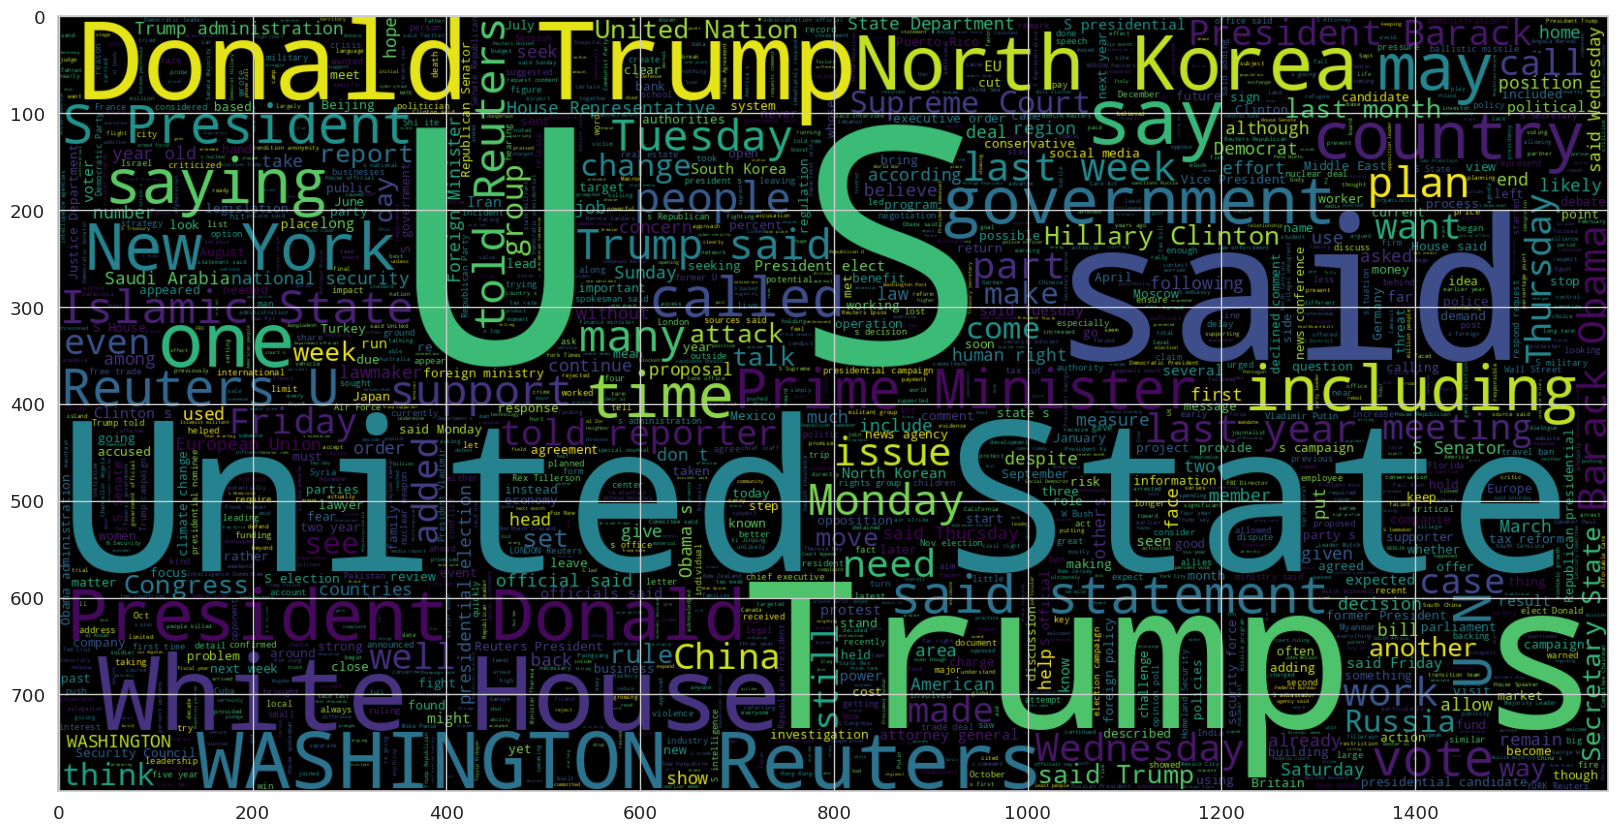

In [17]:
plt.figure(figsize = (20,20)) # Text that is not Fake
wc = WordCloud(max_words = 2000 , width = 1600 , height = 800 , stopwords = STOPWORDS).generate(" ".join(df[df.category == 1].text))
plt.imshow(wc , interpolation = 'bilinear')

**WORDCLOUD FOR FAKE TEXT (LABEL - 0)**

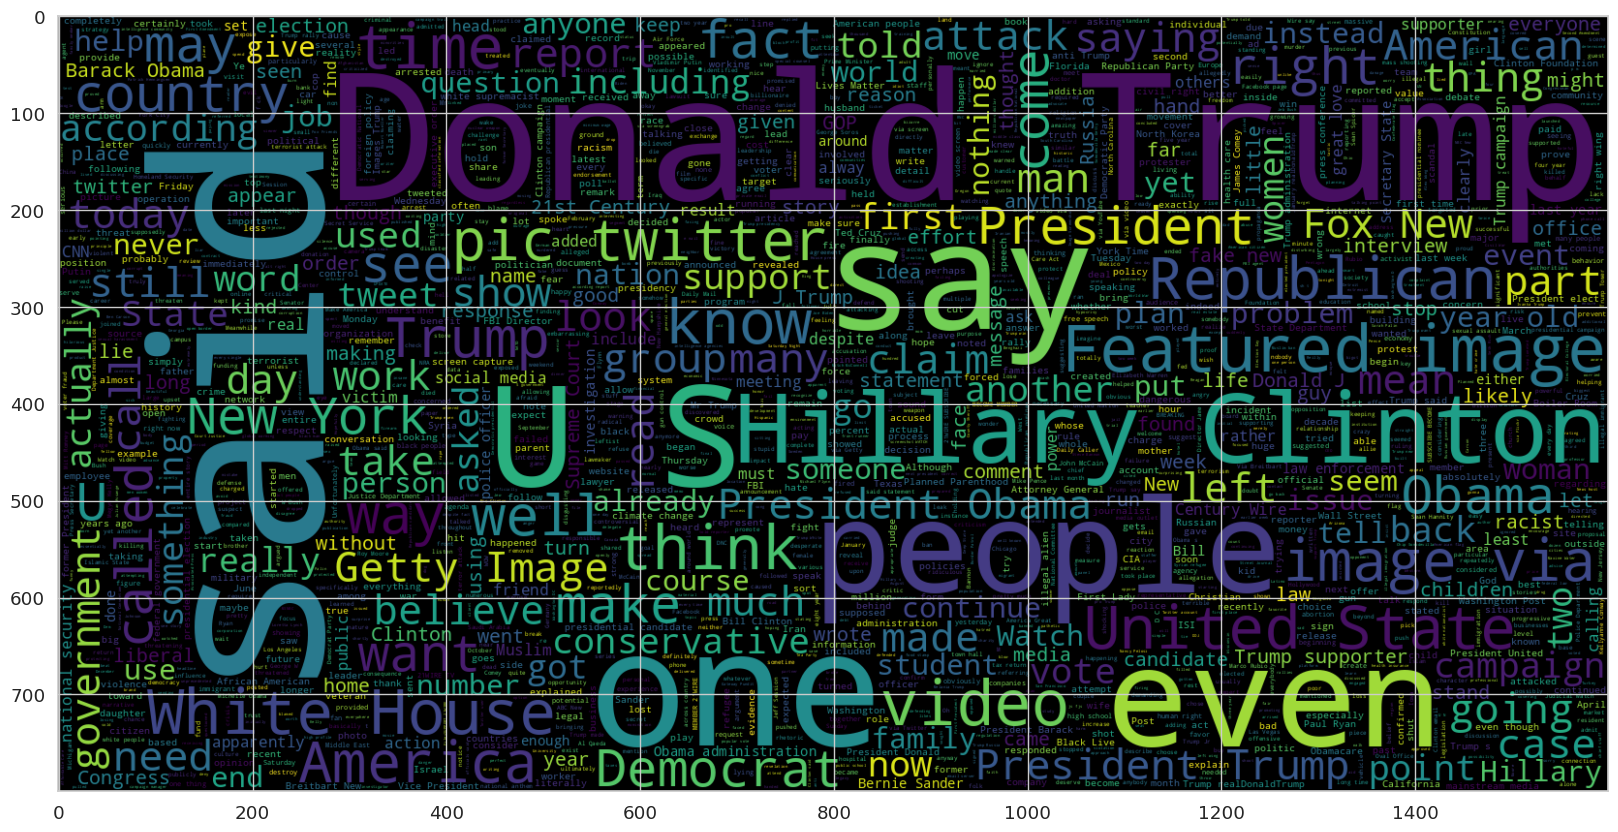

In [18]:
plt.figure(figsize = (20,20)) # Text that is Fake
wc = WordCloud(max_words = 2000 , width = 1600 , height = 800 , stopwords = STOPWORDS).generate(" ".join(df[df.category == 0].text))
plt.imshow(wc , interpolation = 'bilinear')

**Number of characters in texts**

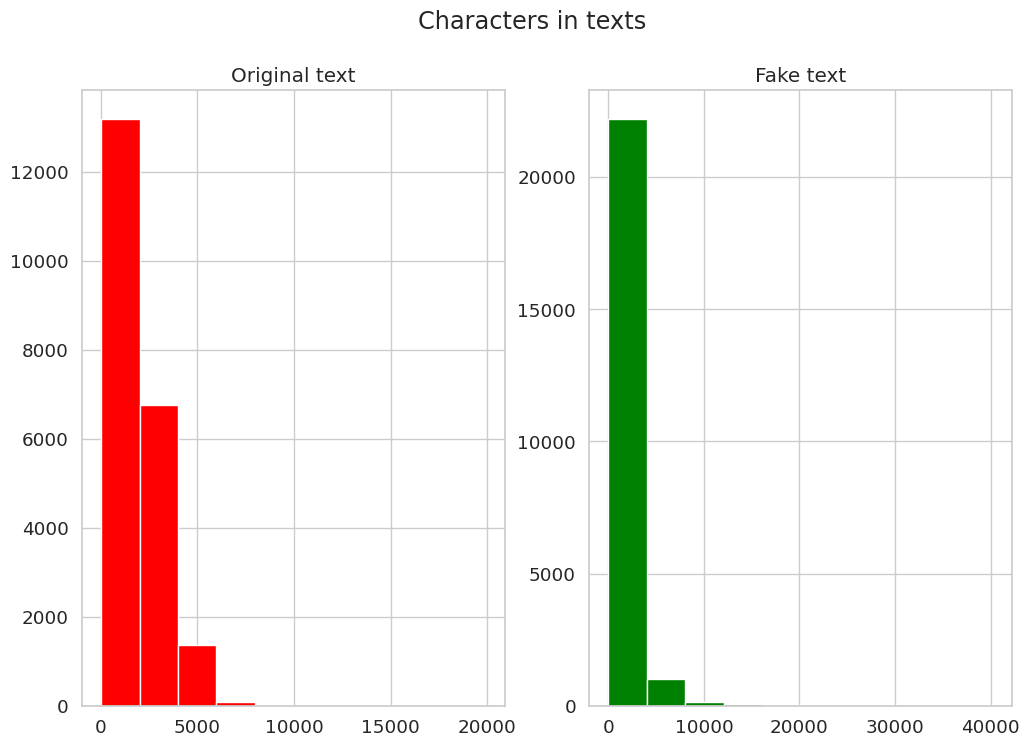

In [19]:
fig,(ax1,ax2)=plt.subplots(1,2,figsize=(12,8))
text_len=df[df['category']==1]['text'].str.len()
ax1.hist(text_len,color='red')
ax1.set_title('Original text')
text_len=df[df['category']==0]['text'].str.len()
ax2.hist(text_len,color='green')
ax2.set_title('Fake text')
fig.suptitle('Characters in texts')
plt.show()

**The distribution of both seems to be a bit different. 2500 characters in text is the most common in original text category while around 5000 characters in text are most common in fake text category.**

**Number of words in each text**

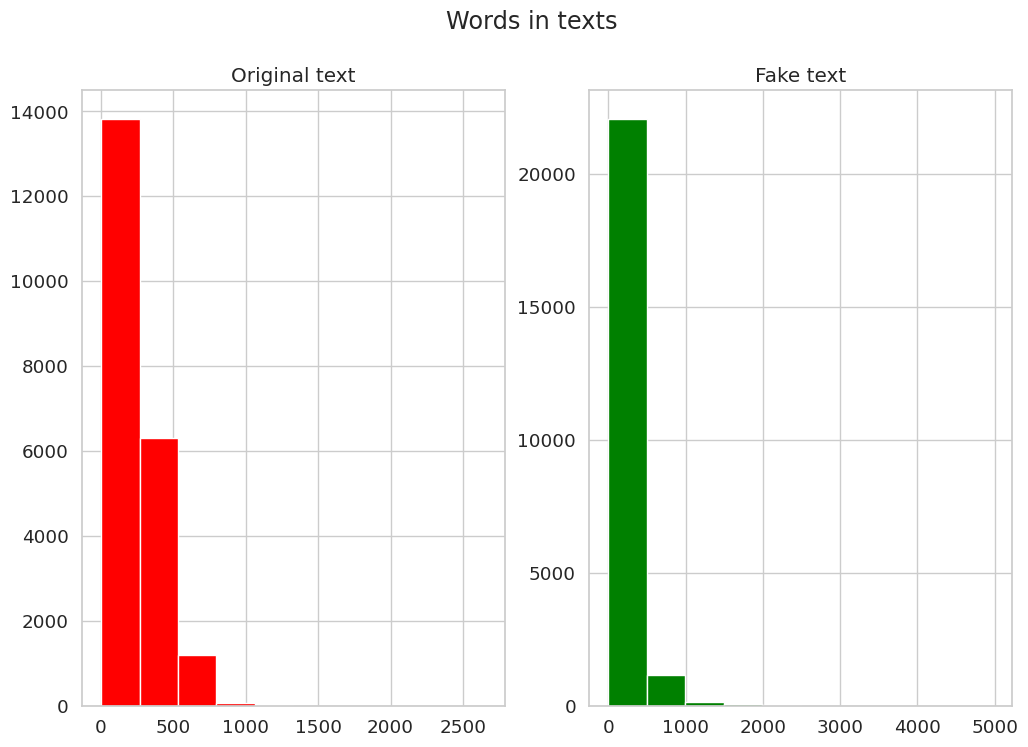

In [20]:
fig,(ax1,ax2)=plt.subplots(1,2,figsize=(12,8))
text_len=df[df['category']==1]['text'].str.split().map(lambda x: len(x))
ax1.hist(text_len,color='red')
ax1.set_title('Original text')
text_len=df[df['category']==0]['text'].str.split().map(lambda x: len(x))
ax2.hist(text_len,color='green')
ax2.set_title('Fake text')
fig.suptitle('Words in texts')
plt.show()

**Average word length in a text**

<ipython-input-21-cbef104b9346>:3: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(word.map(lambda x: np.mean(x)),ax=ax1,color='red')
/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
<ipython-input-21-cbef104b9346>:6: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level fu

Text(0.5, 0.98, 'Average word length in each text')

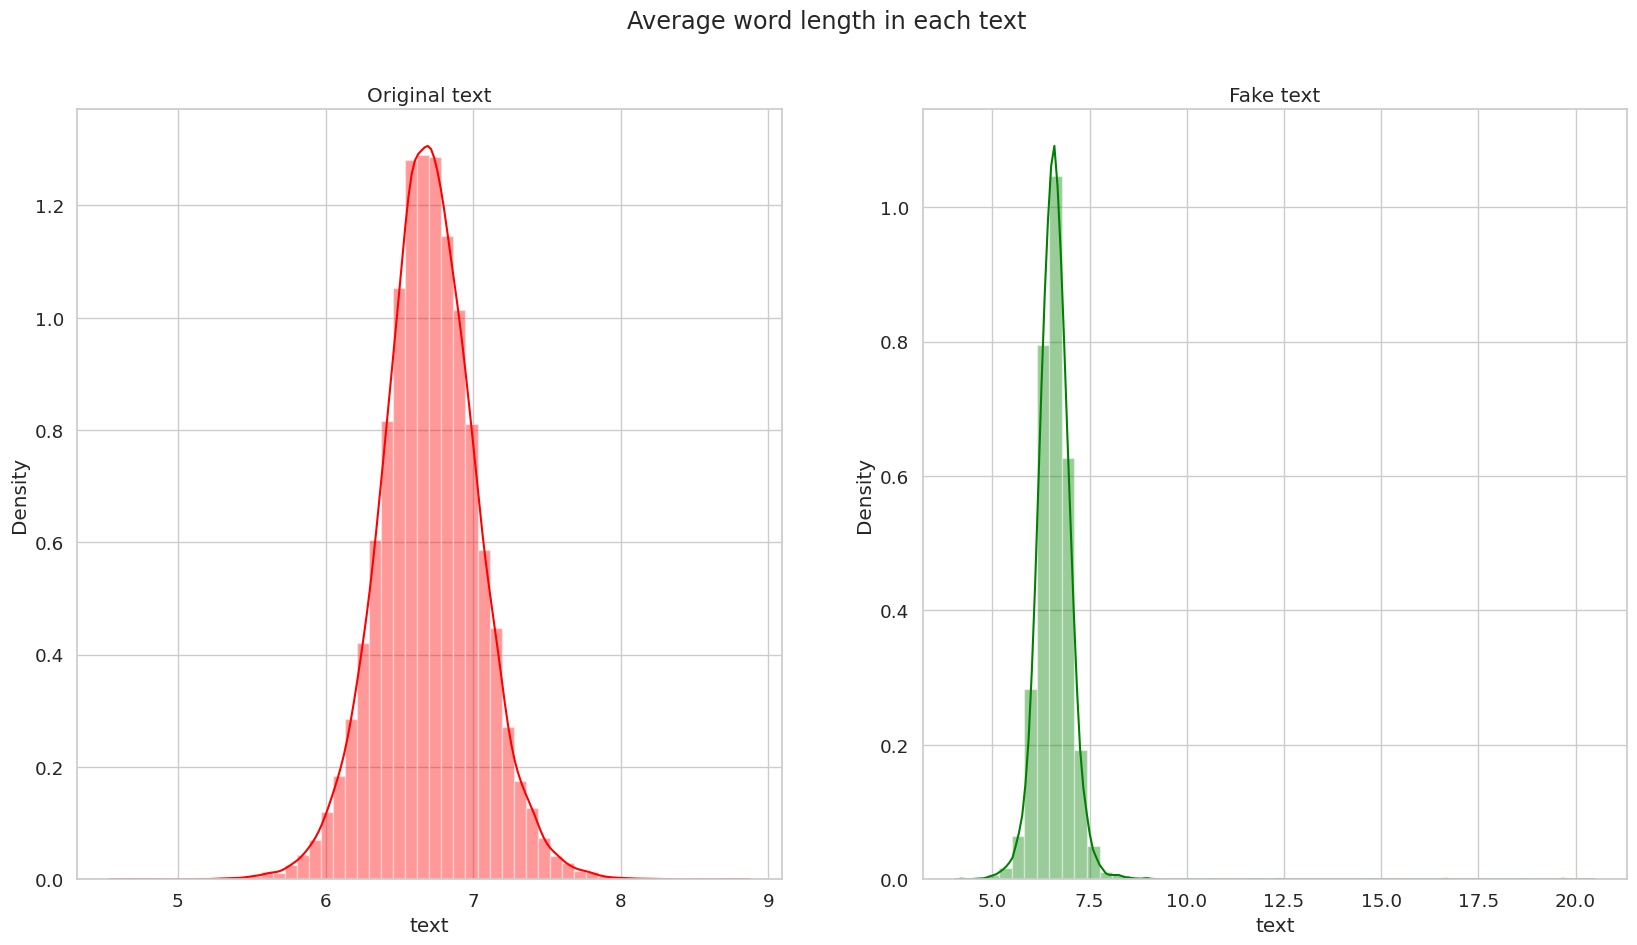

In [21]:
fig,(ax1,ax2)=plt.subplots(1,2,figsize=(20,10))
word=df[df['category']==1]['text'].str.split().apply(lambda x : [len(i) for i in x])
sns.distplot(word.map(lambda x: np.mean(x)),ax=ax1,color='red')
ax1.set_title('Original text')
word=df[df['category']==0]['text'].str.split().apply(lambda x : [len(i) for i in x])
sns.distplot(word.map(lambda x: np.mean(x)),ax=ax2,color='green')
ax2.set_title('Fake text')
fig.suptitle('Average word length in each text')

In [22]:
def get_corpus(text):
    words = []
    for i in text:
        for j in i.split():
            words.append(j.strip())
    return words
corpus = get_corpus(df.text)
corpus[:5]

['WASHINGTON', '(Reuters)', 'head', 'conservative', 'Republican']

In [23]:
from collections import Counter
counter = Counter(corpus)
most_common = counter.most_common(10)
most_common = dict(most_common)
most_common

{'Trump': 111503,
 'said': 93162,
 'would': 54613,
 'U.S.': 50441,
 'President': 33180,
 'people': 33115,
 'also': 30325,
 'one': 29370,
 'Donald': 27795,
 'said.': 26194}

In [24]:
from sklearn.feature_extraction.text import CountVectorizer
def get_top_text_ngrams(corpus, n, g):
    vec = CountVectorizer(ngram_range=(g, g)).fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0)
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:n]

**Unigram Analysis**

<Axes: >

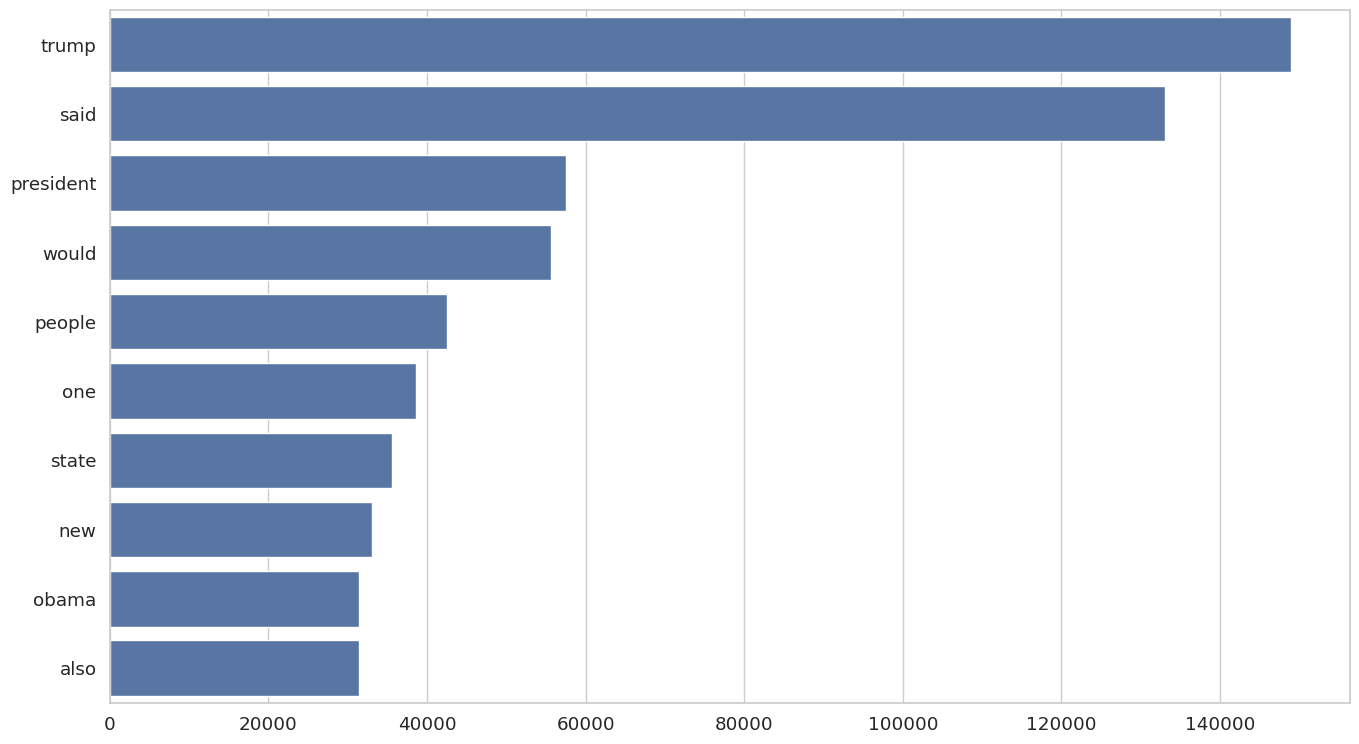

In [25]:
plt.figure(figsize = (16,9))
most_common_uni = get_top_text_ngrams(df.text,10,1)
most_common_uni = dict(most_common_uni)
sns.barplot(x=list(most_common_uni.values()),y=list(most_common_uni.keys()))

**Bigram Analysis**

<Axes: >

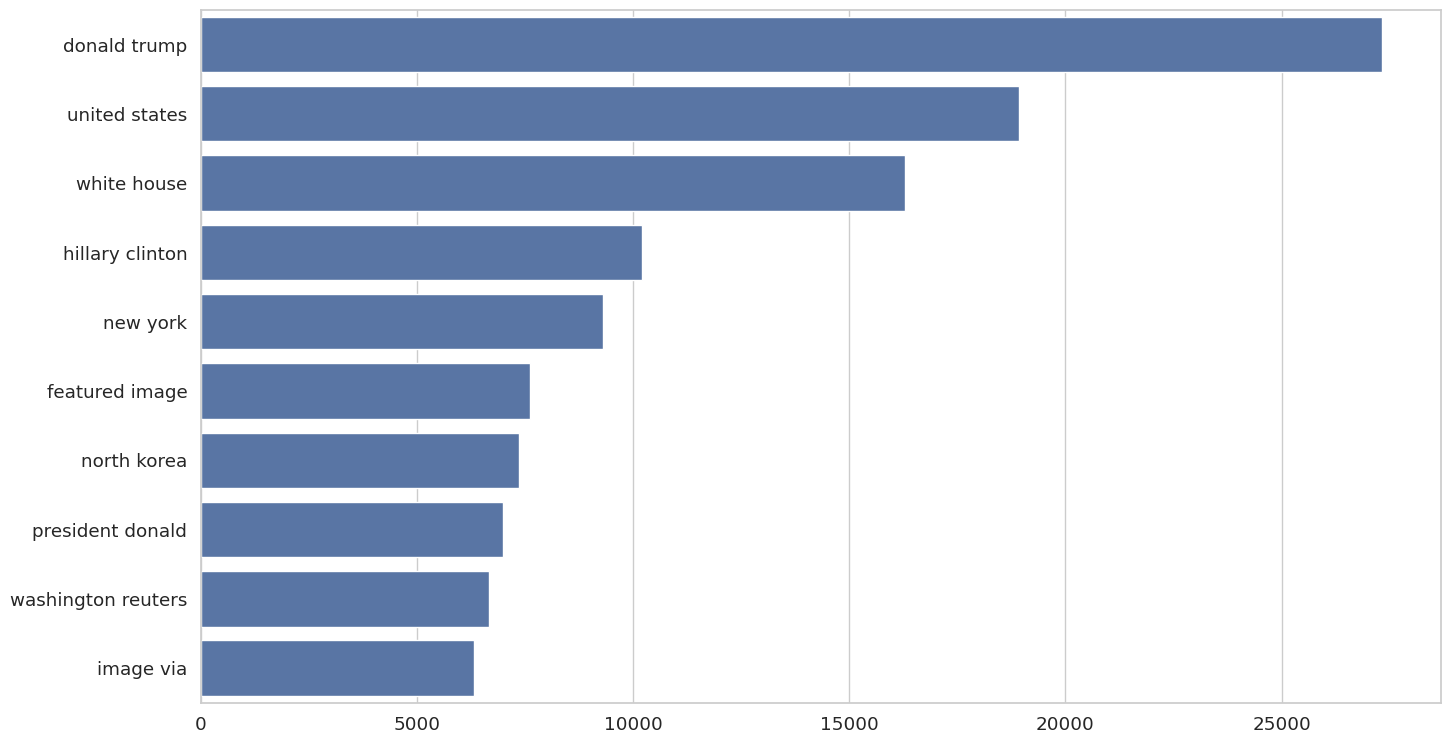

In [26]:
plt.figure(figsize = (16,9))
most_common_bi = get_top_text_ngrams(df.text,10,2)
most_common_bi = dict(most_common_bi)
sns.barplot(x=list(most_common_bi.values()),y=list(most_common_bi.keys()))

**Trigram Analysis**

<Axes: >

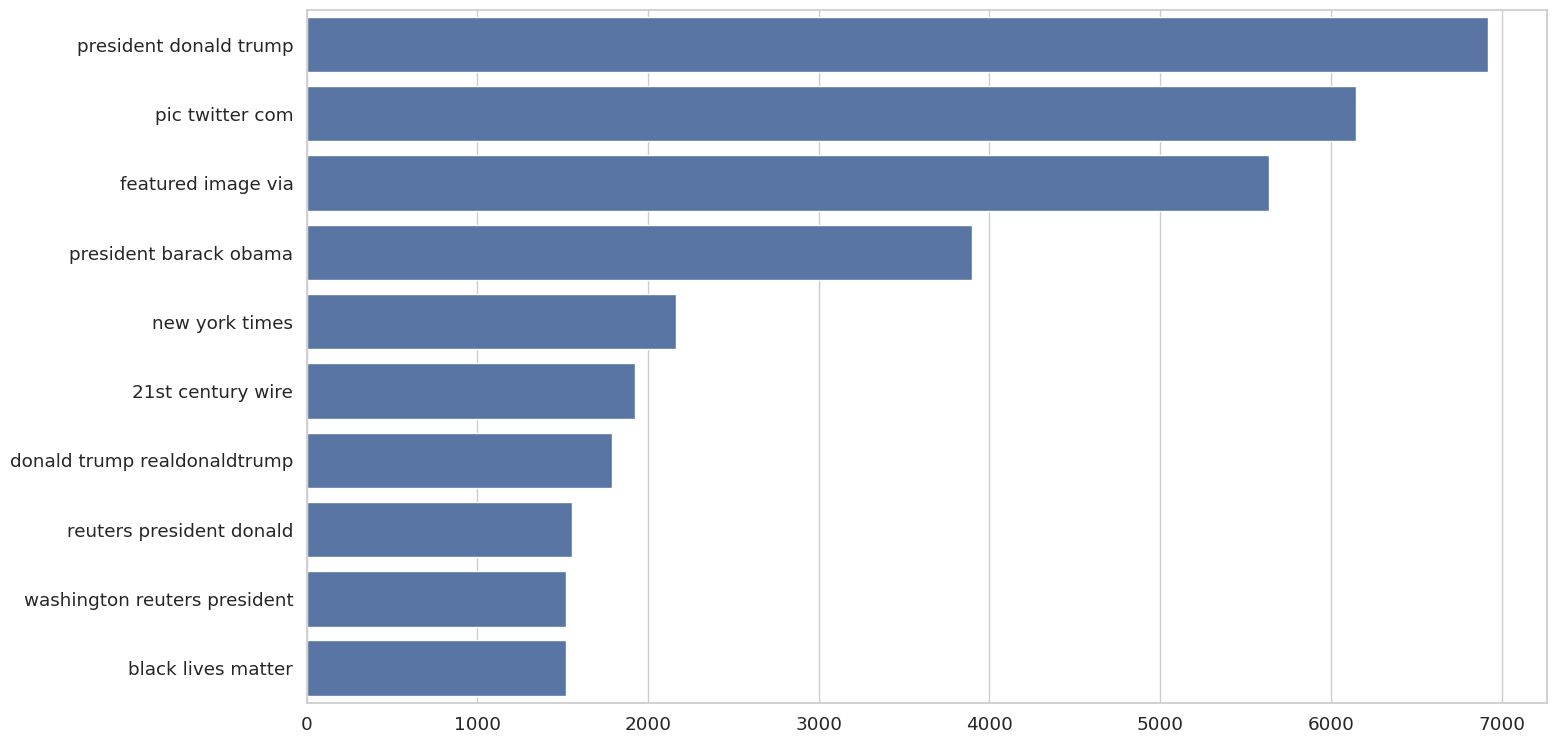

In [27]:
plt.figure(figsize = (16,9))
most_common_tri = get_top_text_ngrams(df.text,10,3)
most_common_tri = dict(most_common_tri)
sns.barplot(x=list(most_common_tri.values()),y=list(most_common_tri.keys()))

**Splitting the data into 2 parts - training and testing data**

In [28]:
x_train,x_test,y_train,y_test = train_test_split(df.text,df.category,random_state = 0)

In [29]:
max_features = 10000
maxlen = 300

**Tokenizing Text -> Repsesenting each word by a number**

**Mapping of orginal word to number is preserved in word_index property of tokenizer**

**Tokenized applies basic processing like changing it to lower case, explicitely setting that as False**

**Lets keep all news to 300, add padding to news with less than 300 words and truncating long ones**

In [30]:
tokenizer = text.Tokenizer(num_words=max_features)
tokenizer.fit_on_texts(x_train)
tokenized_train = tokenizer.texts_to_sequences(x_train)
x_train = sequence.pad_sequences(tokenized_train, maxlen=maxlen)

In [31]:
tokenized_test = tokenizer.texts_to_sequences(x_test)
X_test = sequence.pad_sequences(tokenized_test, maxlen=maxlen)

In [42]:
EMBEDDING_FILE = '/content/drive/MyDrive/Fake-news/glove.twitter.27B.100d.txt'

In [43]:
def get_coefs(word, *arr):
    return word, np.asarray(arr, dtype='float32')
embeddings_index = dict(get_coefs(*o.rstrip().rsplit(' ')) for o in open(EMBEDDING_FILE))

In [45]:
all_embs = np.stack(list(embeddings_index.values()))
emb_mean,emb_std = all_embs.mean(), all_embs.std()
embed_size = all_embs.shape[1]

word_index = tokenizer.word_index
nb_words = min(max_features, len(word_index))
#change below line if computing normal stats is too slow
embedding_matrix = embedding_matrix = np.random.normal(emb_mean, emb_std, (nb_words, embed_size))
for word, i in word_index.items():
    if i >= max_features: continue
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None: embedding_matrix[i] = embedding_vector

In [46]:
batch_size = 256
epochs = 10
embed_size = 100

In [47]:
learning_rate_reduction = ReduceLROnPlateau(monitor='val_accuracy', patience = 2, verbose=1,factor=0.5, min_lr=0.00001)

# TRAINING THE MODEL

In [48]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [49]:
#Defining Neural Network
model = Sequential()
#Non-trainable embeddidng layer
model.add(Embedding(max_features, output_dim=embed_size, weights=[embedding_matrix], input_length=maxlen, trainable=False))
#LSTM
model.add(LSTM(units=128 , return_sequences = True , recurrent_dropout = 0.25 , dropout = 0.25))
model.add(LSTM(units=64 , recurrent_dropout = 0.1 , dropout = 0.1))
model.add(Dense(units = 32 , activation = 'relu'))
model.add(Dense(1, activation='sigmoid'))
model.compile(optimizer=keras.optimizers.Adam(lr = 0.01), loss='binary_crossentropy', metrics=['accuracy'])

In [50]:
model.summary()

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 300, 100)          1000000   
                                                                 
 lstm_2 (LSTM)               (None, 300, 128)          117248    
                                                                 
 lstm_3 (LSTM)               (None, 64)                49408     
                                                                 
 dense_2 (Dense)             (None, 32)                2080      
                                                                 
 dense_3 (Dense)             (None, 1)                 33        
                                                                 
Total params: 1168769 (4.46 MB)
Trainable params: 168769 (659.25 KB)
Non-trainable params: 1000000 (3.81 MB)
_________________________________________________________________


In [51]:
history = model.fit(x_train, y_train, batch_size = batch_size , validation_data = (X_test,y_test) , epochs = epochs , callbacks = [learning_rate_reduction])

Epoch 1/10
132/132 [==============================] - 884s 7s/step - loss: 0.2104 - accuracy: 0.9187 - val_loss: 0.0872 - val_accuracy: 0.9678 - lr: 0.0010
Epoch 2/10
132/132 [==============================] - 861s 7s/step - loss: 0.0820 - accuracy: 0.9708 - val_loss: 0.0453 - val_accuracy: 0.9829 - lr: 0.0010
Epoch 3/10
132/132 [==============================] - 865s 7s/step - loss: 0.0789 - accuracy: 0.9711 - val_loss: 0.0558 - val_accuracy: 0.9802 - lr: 0.0010
Epoch 4/10
132/132 [==============================] - 831s 6s/step - loss: 0.0486 - accuracy: 0.9827 - val_loss: 0.0445 - val_accuracy: 0.9858 - lr: 0.0010
Epoch 5/10
132/132 [==============================] - 863s 7s/step - loss: 0.0789 - accuracy: 0.9712 - val_loss: 0.0643 - val_accuracy: 0.9767 - lr: 0.0010
Epoch 6/10
132/132 [==============================] - ETA: 0s - loss: 0.0438 - accuracy: 0.9846
Epoch 6: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
132/132 [==============================] - 863s 

# ANALYSIS AFTER TRAINING OF MODEL

In [52]:
print("Accuracy of the model on Training Data is - " , model.evaluate(x_train,y_train)[1]*100 , "%")
print("Accuracy of the model on Testing Data is - " , model.evaluate(X_test,y_test)[1]*100 , "%")

1053/1053 [==============================] - 224s 213ms/step - loss: 0.0129 - accuracy: 0.9964
Accuracy of the model on Training Data is -  99.64362978935242 %
351/351 [==============================] - 75s 212ms/step - loss: 0.0162 - accuracy: 0.9962
Accuracy of the model on Testing Data is -  99.61692690849304 %


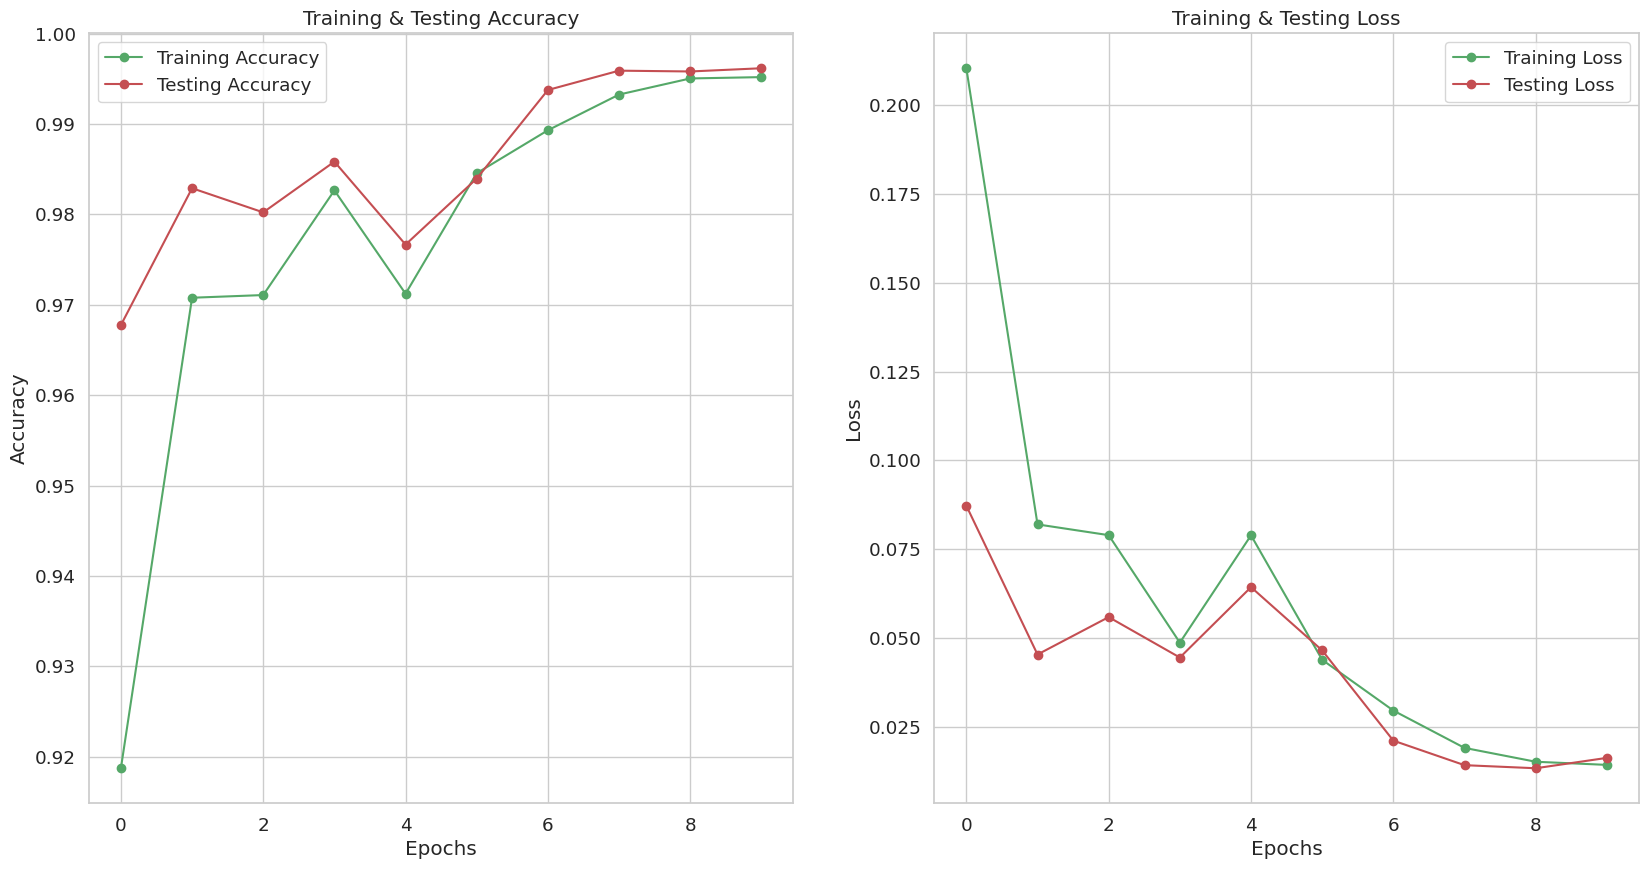

In [53]:
epochs = [i for i in range(10)]
fig , ax = plt.subplots(1,2)
train_acc = history.history['accuracy']
train_loss = history.history['loss']
val_acc = history.history['val_accuracy']
val_loss = history.history['val_loss']
fig.set_size_inches(20,10)

ax[0].plot(epochs , train_acc , 'go-' , label = 'Training Accuracy')
ax[0].plot(epochs , val_acc , 'ro-' , label = 'Testing Accuracy')
ax[0].set_title('Training & Testing Accuracy')
ax[0].legend()
ax[0].set_xlabel("Epochs")
ax[0].set_ylabel("Accuracy")

ax[1].plot(epochs , train_loss , 'go-' , label = 'Training Loss')
ax[1].plot(epochs , val_loss , 'ro-' , label = 'Testing Loss')
ax[1].set_title('Training & Testing Loss')
ax[1].legend()
ax[1].set_xlabel("Epochs")
ax[1].set_ylabel("Loss")
plt.show()

In [64]:
# Assuming you have already defined and trained your model

# Predict probabilities for each class
pred_probs = model.predict(X_test)

# Convert probabilities to class labels
pred_classes = (pred_probs > 0.5).astype('int')  # Assuming binary classification with a threshold of 0.5

# Display the first 5 predictions
print(pred_classes[:5])

351/351 [==============================] - 74s 211ms/step
[[0]
 [0]
 [0]
 [0]
 [1]]


In [65]:
print(classification_report(y_test, pred_classes, target_names = ['Fake','Not Fake']))

              precision    recall  f1-score   support

        Fake       1.00      0.99      1.00      5858
    Not Fake       0.99      1.00      1.00      5367

    accuracy                           1.00     11225
   macro avg       1.00      1.00      1.00     11225
weighted avg       1.00      1.00      1.00     11225



In [66]:
cm = confusion_matrix(y_test,pred_classes)
cm

array([[5824,   34],
       [   9, 5358]])

In [67]:
cm = pd.DataFrame(cm , index = ['Fake','Original'] , columns = ['Fake','Original'])

Text(88.25, 0.5, 'Actual')

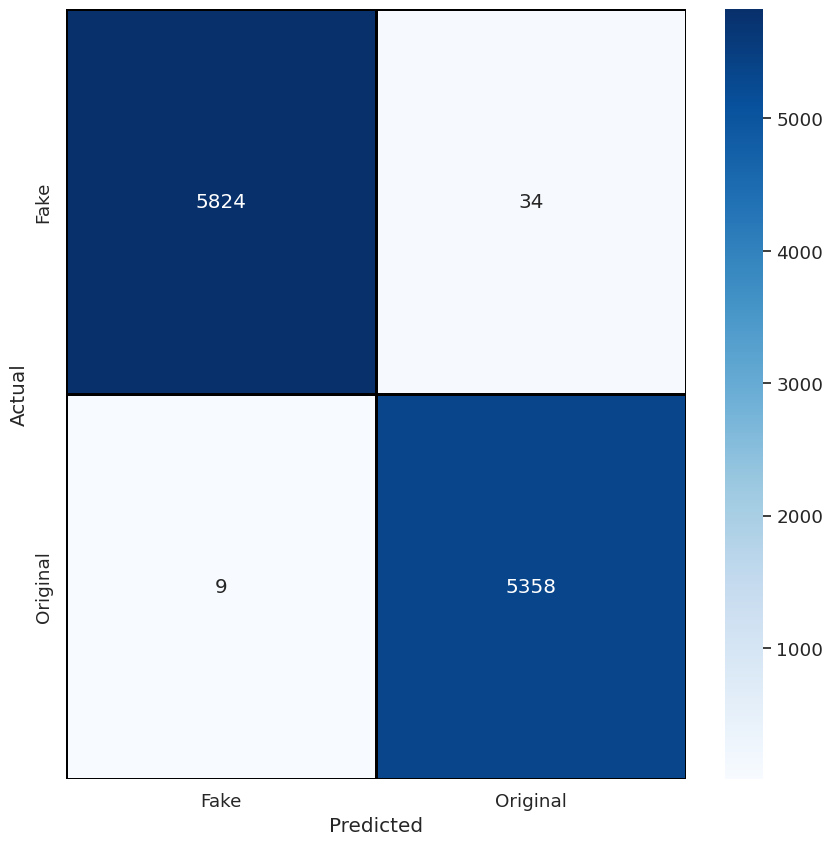

In [68]:
plt.figure(figsize = (10,10))
sns.heatmap(cm,cmap= "Blues", linecolor = 'black' , linewidth = 1 , annot = True, fmt='' , xticklabels = ['Fake','Original'] , yticklabels = ['Fake','Original'])
plt.xlabel("Predicted")
plt.ylabel("Actual")